# Benchmarking Results

In [1]:
import numpy as np
import pandas as pd
import notebook_helper_functions.plot_functions as plot_funcs

TODO
1. Pick notebook wide matplotlib color scheme
2. Check and make sure rate calculation are correct (dynamically based on batch or replicate size)
3. Decide how to plot variability - SEM? STDEV? Use max were appropriate (i.e. max memory footprint)?
4. Maybe work on SQL load?
5. Finish final optimized benchmark with plots and analysis
6. Add notes/discussion
7. Save plots for slides
8. Include evaluation/samples of summaries somehow
9. Quantify accumulated speed up at each step.

## 1. Baseline execute time
### TODO
1. ~~Change milliseconds back to seconds on plots.~~
2. ~~Add pie chart?~~
3. Pretty format summary table
4. Move summary to data analysis helper functions
5. Enlarge font

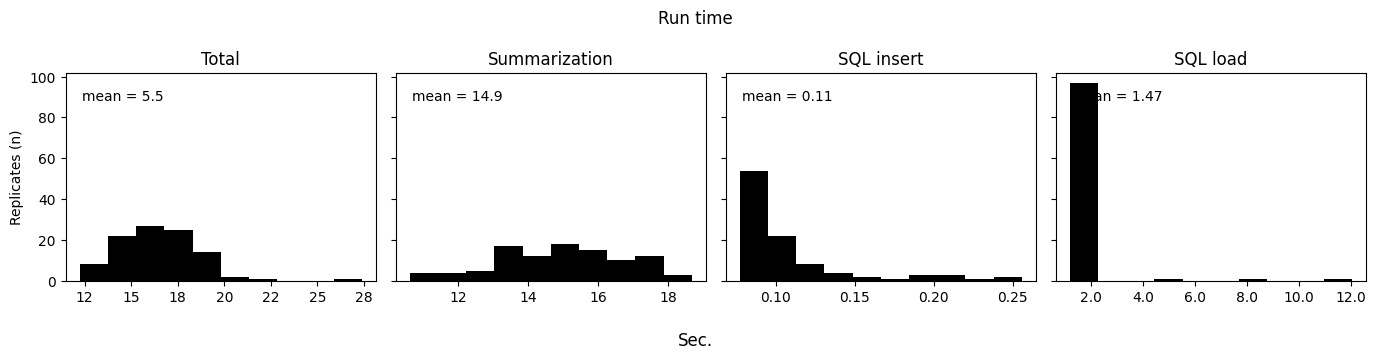

In [2]:
data = plot_funcs.baseline_execution_plot('../benchmarks/baseline_execute_time/results.csv')

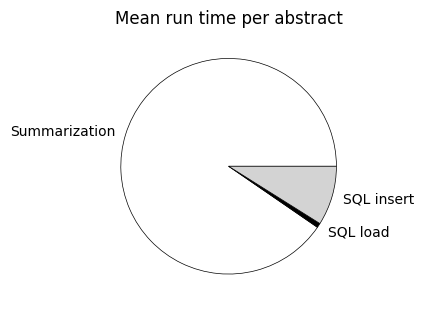

In [3]:
plot_funcs.baseline_execution_pie('../benchmarks/baseline_execute_time/results.csv')

**Conclusion**: Not surprisingly, the most time is spent in inference - waiting for the model to summarize the abstract. Focus optimization effort there.

## 2. Huggingface device map
### TODO
1. Move summary table to data analysis helper functions

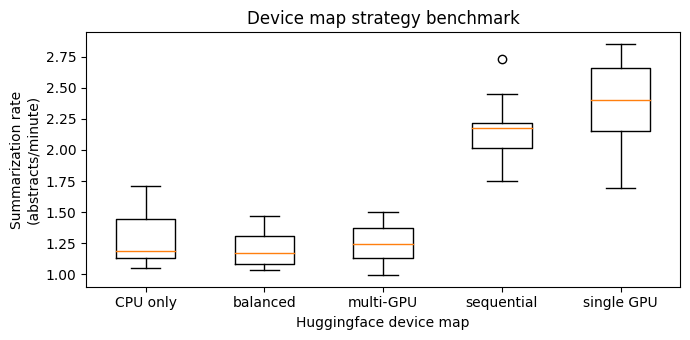

,device map strategy,mean summarization rate (abstracts/min.)
0,CPU only,1.30
1,balanced,1.20
2,multi-GPU,1.25
3,sequential,2.18
4,single GPU,2.36


In [4]:
data, plt = plot_funcs.device_map_plot('../benchmarks/huggingface_device_map/results.csv')

plt.show()

table = data.groupby(['device map strategy'])['summarization rate (abstracts/min.)'].mean().round(2)
table = pd.DataFrame({'device map strategy':table.index, 'mean summarization rate (abstracts/min.)':table.values})
table

**Conclusion**: Single GPU or sequential is the best device map. Focus on single GPU moving forward so that data parallel inference can be run on multiple GPUs.

## 3. Parallel summarization
### TODO
1. Add linear plot for just GPU?
2. Fit/model rate and memory as function of workers
3. Move summary table to data analysis helper functions
4. Use data analysis function to deal with OOMs
5. Move plot legend to first plot

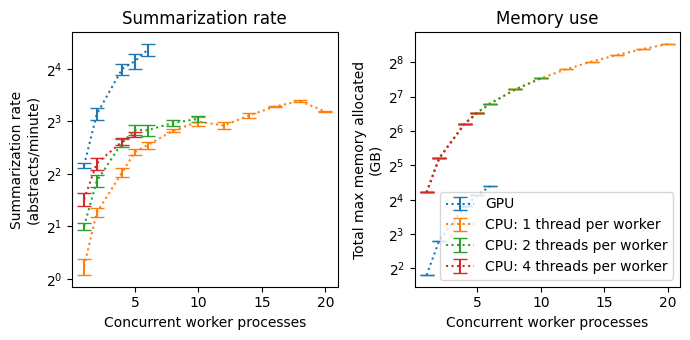

Mean summarization rate (abstracts/min.)


workers,1,2,4,5,6,8,10,12,14,16,18,20
device,,,,,,,,,,,,
CPU: 1 thread per worker,1.18,2.40,4.08,5.33,5.84,7.06,7.97,7.56,8.65,9.71,10.45,9.09
CPU: 2 threads per worker,2.00,3.63,6.04,7.14,7.11,7.83,8.26,OOM,OOM,OOM,OOM,OOM
CPU: 4 threads per worker,2.86,4.59,6.12,6.71,OOM,OOM,OOM,OOM,OOM,OOM,OOM,OOM
GPU,4.47,8.78,15.97,17.70,20.55,OOM,OOM,OOM,OOM,OOM,OOM,OOM


In [5]:
data, plt = plot_funcs.parallel_summarization_plot('../benchmarks/parallel_summarization/results.csv')

plt.show()

print('Mean summarization rate (abstracts/min.)')
table = data.groupby(['device', 'workers'])['summarization rate (abstracts/min.)'].mean().round(2)
table = table.unstack()
table.fillna('OOM', inplace=True)
table

**Conclusion** Not surprisingly, GPU still beats CPU, even though more parallel jobs can run on CPU due to more available system memory.

## 4. Model quantization
### TODO
1. Plot peak memory use
2. Run more replicates to get a sense of variability
3. Move summary table to data analysis helper functions
4. Add fig title

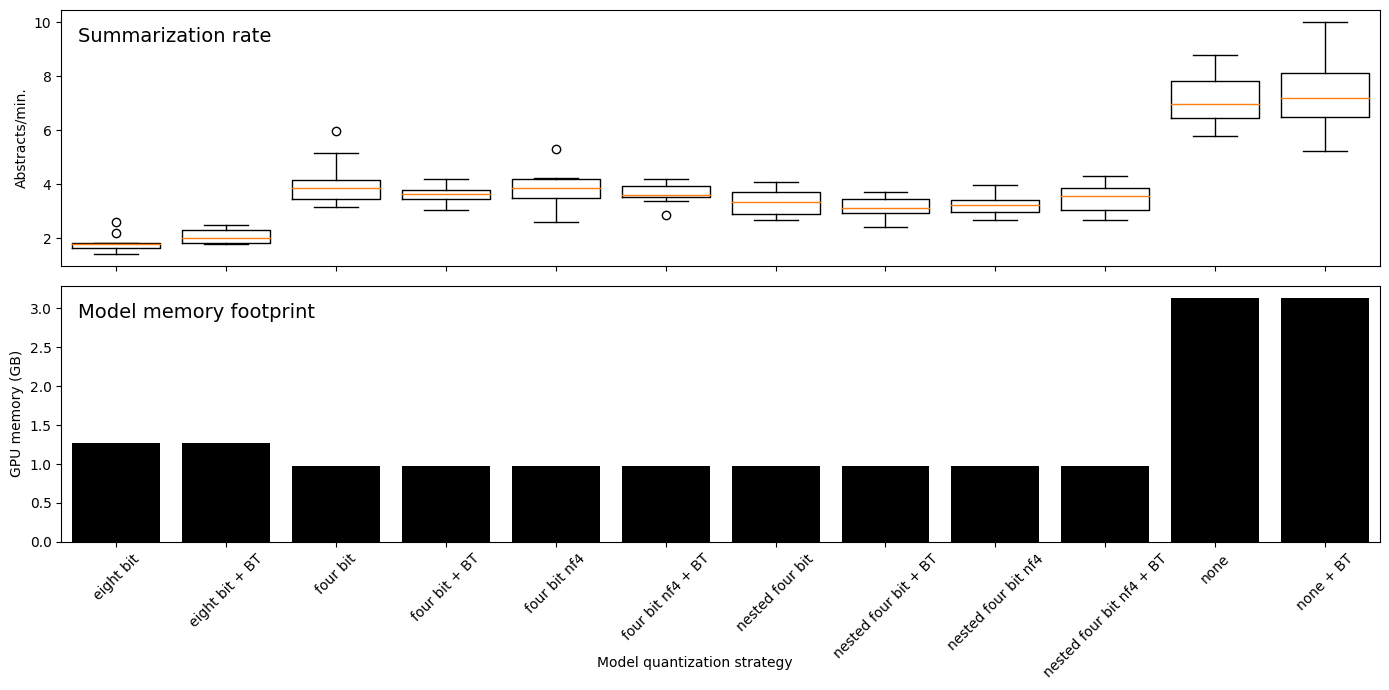

,summarization rate (abstracts/min.),model GPU memory footprint (GB),max memory allocated (GB)
quantization strategy,,,
eight bit,1.85,1.26,1.46
eight bit + BT,2.08,1.26,1.45
four bit,4.07,0.97,1.17
four bit + BT,3.62,0.97,1.18
four bit nf4,3.82,0.97,1.17
four bit nf4 + BT,3.68,0.97,1.18
nested four bit,3.33,0.97,1.15
nested four bit + BT,3.12,0.97,1.15
nested four bit nf4,3.24,0.97,1.15


In [6]:
data = plot_funcs.model_quantization_plot('../benchmarks/model_quantization/results.csv')

table = data.groupby(['quantization strategy'])[['summarization rate (abstracts/min.)', 'model GPU memory footprint (GB)', 'max memory allocated (GB)']].mean().round(2)
table

**Conclusion**: Quantization can decrease the model's memory footprint by about 3-fold, but at a significant cost to inference speed.

## 5. Batched summarization
### TODO
1. Finish batch sizes
2. Try two plots, one for quantized, one for un-quantized: memory vs speed

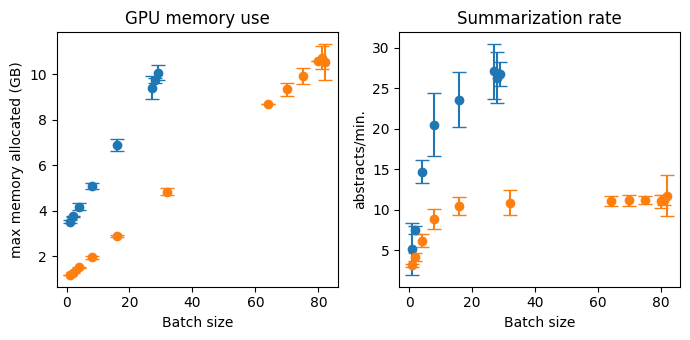

max memory allocated (GB)        \
quantization              four bit nf4  none   
batch size                                     
1                                  1.2   3.5   
2                                  1.3   3.7   
4                                  1.5   4.2   
8                                  2.0   5.1   
16                                 2.9   6.9   
27                                 nan   9.4   
28                                 nan   9.7   
29                                 nan  10.1   
32                                 4.8   nan   
64                                 8.7   nan   
70                                 9.3   nan   
75                                 9.9   nan   
80                                10.6   nan   
81                                10.5   nan   
82                                10.7   nan   

             summarization rate (abstracts/min.)        
quantization                        four bit nf4  none  
batch size                                              
1                                            3.2   5.2  
2                                            4.2   7.5  
4                                            6.2  14.7  
8                                            8.9  20.5  
16                                          10.5  23.6  
27                                           nan  27.1  
28                                           nan  26.3  
29                                           nan  26.7  
32                                          10.9   nan  
64                                          11.1   nan  
70                                          11.2   nan  
75                                          11.2   nan  
80                                          11.1   nan  
81                                          11.8   nan  
82                                          11.2   nan

In [7]:
data, plt = plot_funcs.batch_summarization_plot(
    datafile='../benchmarks/batched_summarization/results.csv',
    unique_condition_columns=[
        'batch size',
        'quantization'
    ],
    oom_columns=[
        'summarization time (sec.)',
        'summarization rate (abstracts/sec.)',
        'model memory footprint (bytes)',
        'max memory allocated (bytes)',
    ],
    quantization_method='four bit nf4',
    str_columns=['quantization'], 
    int_columns=[
        'model memory footprint (bytes)',
        'max memory allocated (bytes)'
    ], 
    float_columns=[
        'summarization time (sec.)',
        'summarization rate (abstracts/sec.)',
    ],
    oom_replacement_val=np.nan
)

plt.show()

table = data.groupby(['batch size', 'quantization'])[['max memory allocated (GB)', 'summarization rate (abstracts/min.)']].mean().round(1)
table = table.unstack()
table = table.astype(str)
table.replace('<NA>', 'nan', inplace=True)
table


**Conclusion**: Quantization allows for larger batch sizes due to the smaller memory footprint of the model, but the resulting speedup is not enough to make up for the lower summarization rate quantization also causes. Don't bother quantizing the model.

## 5. Parallel batched summarization
### TODO:
1. Finish data collection

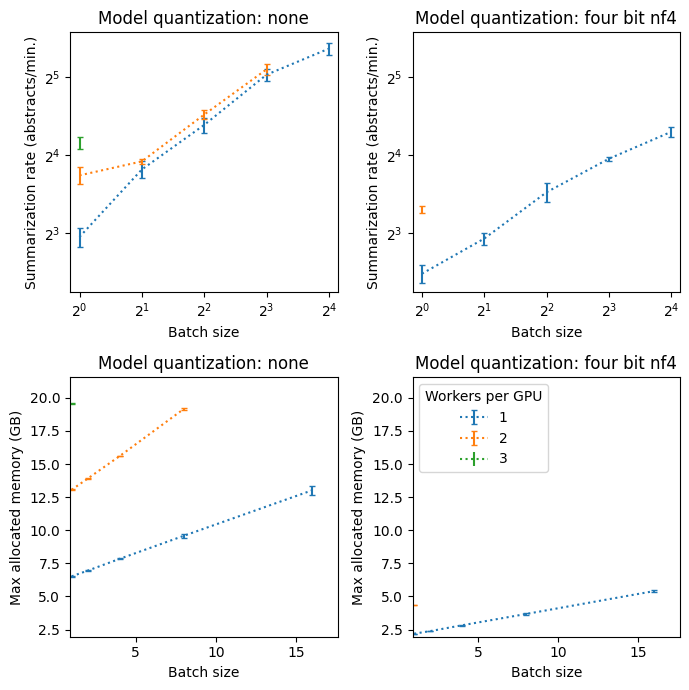

Mean max memory allocated (GB)


quantization                four bit nf4  none
workers per GPU batch size                    
1               1                    2.2   6.5
                2                    2.4   6.9
                4                    2.8   7.8
                8                    3.7   9.6
                16                   5.4  13.0
2               1                    4.4  13.1
                2                   <NA>  13.9
                4                   <NA>  15.6
                8                   <NA>  19.2
3               1                   <NA>  19.6

In [8]:
data, plt = plot_funcs.parallel_batched_summarization_plot(
    datafile='../benchmarks/parallel_batched_summarization/results.csv',
    unique_condition_columns=[
        'batch size',
        'quantization',
        'workers per GPU'
    ],
    oom_columns=[
        'summarization time (sec.)',
        'summarization rate (abstracts/sec.)',
        'model memory footprint (bytes)',
        'max memory allocated (bytes)',
    ],
    quantization_method='four bit nf4',
    str_columns=['quantization'], 
    int_columns=[
        'model memory footprint (bytes)',
        'max memory allocated (bytes)'
    ], 
    float_columns=[
        'summarization time (sec.)',
        'summarization rate (abstracts/sec.)',
    ],
    oom_replacement_val=np.nan    
)

plt.show()

print('Mean max memory allocated (GB)')
table = data[data['workers per GPU'] <= 3].groupby(['workers per GPU', 'batch size', 'quantization'])['max memory allocated (GB)'].mean().round(1)
table = table.unstack()
table

**Conclusion**: Same as perviously, more quantized models can be run in parallel due to memory savings, but the speed up due to increased parallelism is not enough to compete with the un-quantized model. One worker per GPU with the largest batch size that will fit in memory (16) wins.

## 6. SQL Insert
### TODO:
1. Re-run with larger/more replicates to decrease variability

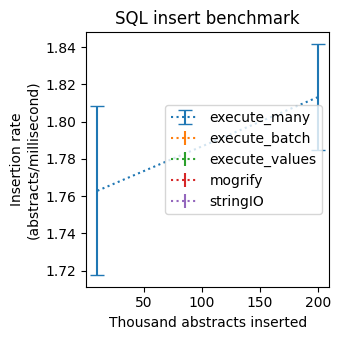

Mean insert rate (abstracts/millisecond)


insert strategy,execute_many
abstracts,
10000,1.76
200000,1.81


In [9]:
data, plt = plot_funcs.sql_insert_plot('../benchmarks/sql_insert/results.csv')

plt.show()

print('Mean insert rate (abstracts/millisecond)')
table = data.groupby(['abstracts', 'insert strategy'])['insert rate (abstracts/millisecond)'].mean().round(2)
table = table.unstack()
table

**Conclusion**: StringIO with 200,000 abstracts per call wins by a mile. SQL was definitely not the bottleneck here - but, why not speed it up?

## 7. Final result

In [10]:
total_secs = 3580000 * 16.5
total_mins = total_secs / 60
total_hrs = total_mins / 60
total_unoptimized_days = total_hrs / 24
print(f'Estimated total summarization time, before optimization: {round(total_unoptimized_days, 0)} days.')

total_mins = 3580000 * (1/100)
total_hrs = total_mins / 60
total_optimized_days = total_hrs / 24
print(f'Estimated total summarization time, after optimization: {round(total_optimized_days, 0)} days.')

print(f'\nTotal speed-up: {round(total_unoptimized_days / total_optimized_days, 0)} fold.')

Estimated total summarization time, before optimization: 684.0 days.
Estimated total summarization time, after optimization: 25.0 days.

Total speed-up: 28.0 fold.
